BIDIRECTIONAL LSTM FOR 1 FEATURE DURATION 24 HOURS

Defining feature and duration

In [84]:
num_feature = 1
time_step = 24

Importing library

In [85]:
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential, load_model
from keras.layers import Bidirectional, LSTM, Dense
from sklearn.metrics import mean_squared_error, mean_absolute_error
import xgboost as xgb

Importing data

In [86]:
filename = './data/07-09-2023.csv'
data = []
with open(filename, 'r') as file:
    csv_reader = csv.reader(file)
    for row in csv_reader:
        data.append(row)
        
df = pd.DataFrame(data)
df.columns = ["Record_ID","Time","Timestamp","Temperature","Disolved Oxygen","Salinity","pH","Turbidity"]
df['Record_ID'] = df["Record_ID"].astype(int)
df['Time'] = df["Time"].astype(str)
df['Temperature'] = df["Temperature"].astype(float)
df['Disolved Oxygen'] = df["Disolved Oxygen"].astype(float)
df['Salinity'] = df["Salinity"].astype(float)
df['pH'] = df["pH"].astype(float)
df['Turbidity'] = df["Turbidity"].astype(float)
df = df.drop(columns='Timestamp')
df = df.drop(columns='Record_ID')
df['Time'] = pd.to_datetime(df['Time'],format="%d/%m/%Y %H:%M:%S")
df.set_index('Time', inplace=True)
df.index = pd.to_datetime(df.index)
df.sort_index(inplace=True)
df.describe()
# df = df.dropna()

,Temperature,Disolved Oxygen,Salinity,pH,Turbidity
count,2.165460e+05,2.165460e+05,216546.000000,2.165460e+05,2.165460e+05
mean,-1.045808e+03,-1.066890e+03,28.388756,-1.066845e+03,-8.721180e+02
std,3.531911e+05,3.531911e+05,353.514121,3.531911e+05,3.531925e+05
min,-1.162173e+08,-1.162173e+08,-116217.300000,-1.162173e+08,-1.162173e+08
25%,2.540000e+01,5.000000e+00,31.300000,6.600000e+00,1.380000e+01
50%,2.810000e+01,6.600000e+00,35.500000,7.200000e+00,2.810000e+01
75%,2.960000e+01,7.500000e+00,35.700000,7.800000e+00,8.200000e+01
max,4.430000e+01,2.972360e+04,47.800000,7.190000e+01,1.089990e+04


In [87]:
temp = df['Temperature']
temp = temp[temp>=18]
temp = temp.resample('H').mean()

Splitting train and test data

In [88]:
train = temp[(temp.index.year<2022) | ((temp.index.year==2022)&(temp.index.month<9))]
test = temp[(temp.index.year>2022) | ((temp.index.year==2022)&(temp.index.month>=9))]

Observe data

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


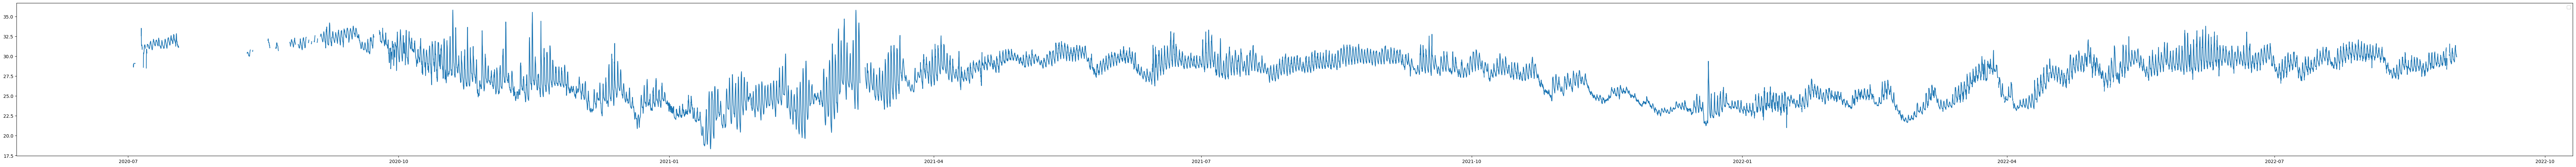

In [89]:
plt.figure(figsize=(100,6))
plt.plot(train.index,train.to_numpy().ravel())
plt.legend()
plt.show()

In [90]:
# train.resample('D').agg(['mean', 'sum', 'std']).plot(subplots = True, title='Temperature resampled over day', color='red')
# plt.show()

In [91]:
# train.resample('M').mean().plot(kind='bar')
# plt.ylabel('Temperature')
# plt.title('Temperature per month (averaged over month)')
# plt.show()

Prepare training data

In [92]:
def split_train(array: np.array, duration: int):
    x = np.empty((0,duration))
    y = np.empty((0,1))
    for i in range(array.shape[0]-duration-1):
        new_row_x = array[i:i+duration].reshape(1, duration)
        new_row_y = array[i+duration].reshape(1, 1)
        if (np.any(np.isnan(new_row_x)) or np.any(np.isnan(new_row_y))): continue
        else:
            x = np.concatenate((x,new_row_x),axis=0)
            y = np.concatenate((y,new_row_y),axis=0)
    return x.reshape(x.shape[0],x.shape[1],num_feature), y.reshape(y.shape[0],1)

Bidirectional LSTM

Create Model

In [93]:
x_train, y_train = split_train(train.to_numpy(),time_step)

In [94]:
model_1 = Sequential()
model_1.add(Bidirectional(LSTM(64,activation='relu', input_shape=(time_step,num_feature))))
model_1.add(Dense(1))
model_1.compile(optimizer='adam', loss='mse')
model_1.build(input_shape=(1,time_step,num_feature))
model_1.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_9 (Bidirecti  (1, 128)                  33792     
 onal)                                                           
                                                                 
 dense_9 (Dense)             (1, 1)                    129       
                                                                 
Total params: 33921 (132.50 KB)
Trainable params: 33921 (132.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [95]:
model_1.fit(x_train, y_train, epochs=10)
model_1.save('./model/Bidirect-LSTM_24h_1feature_64node.h5')

Epoch 1/10
486/486 [==============================] - 5s 7ms/step - loss: 4.2774
Epoch 2/10
486/486 [==============================] - 4s 7ms/step - loss: 0.1738
Epoch 3/10
486/486 [==============================] - 3s 7ms/step - loss: 0.1486
Epoch 4/10
486/486 [==============================] - 3s 7ms/step - loss: 0.1513
Epoch 5/10
486/486 [==============================] - 3s 7ms/step - loss: 0.1218
Epoch 6/10
486/486 [==============================] - 3s 7ms/step - loss: 0.1137
Epoch 7/10
486/486 [==============================] - 3s 7ms/step - loss: 0.1120
Epoch 8/10
486/486 [==============================] - 3s 7ms/step - loss: 0.1128
Epoch 9/10
486/486 [==============================] - 3s 7ms/step - loss: 0.1107
Epoch 10/10
486/486 [==============================] - 3s 7ms/step - loss: 0.1061


e:\EXTERNALC\Python\311\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [96]:
x_test, y_test = split_train(test.to_numpy(),time_step)
y_predict = np.array(model_1.predict(x_test))
y_test = y_test.ravel()
y_predict = y_predict.ravel()
mse = mean_squared_error(y_test, y_predict)
mae = mean_absolute_error(y_test, y_predict)
print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)

267/267 [==============================] - 1s 3ms/step
Mean Squared Error (MSE): 0.25735831392082553
Mean Absolute Error (MAE): 0.38521115355866464


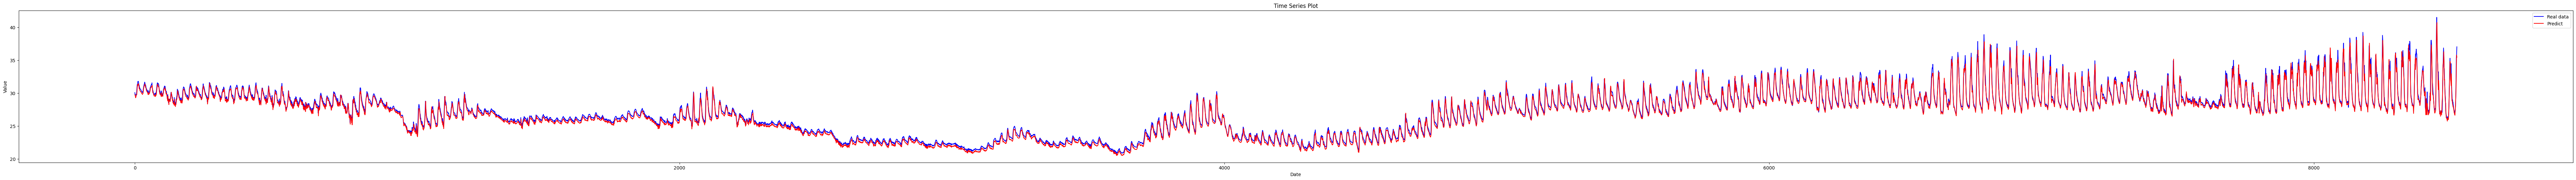

In [97]:
time = np.arange(len(y_predict))
plt.figure(figsize=(100,6))
plt.plot(time, y_test, label="Real data", color='blue')
plt.plot(time, y_predict, label="Predict",color='red')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Time Series Plot')
plt.legend()
plt.show()

In [98]:
x_train, y_train = split_train(train.to_numpy(),time_step)

In [99]:
model_2 = Sequential()
model_2.add(Bidirectional(LSTM(32,activation='relu', input_shape=(time_step,num_feature))))
model_2.add(Dense(1))
model_2.compile(optimizer='adam', loss='mse')
model_2.build(input_shape=(1,time_step,num_feature))
model_2.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_10 (Bidirect  (1, 64)                   8704      
 ional)                                                          
                                                                 
 dense_10 (Dense)            (1, 1)                    65        
                                                                 
Total params: 8769 (34.25 KB)
Trainable params: 8769 (34.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [100]:
model_2.fit(x_train, y_train, epochs=10)
model_2.save('./model/Bidirect-LSTM_24h_1feature_32node.h5')

Epoch 1/10
486/486 [==============================] - 5s 5ms/step - loss: 43.8602
Epoch 2/10
486/486 [==============================] - 3s 5ms/step - loss: 0.4879
Epoch 3/10
486/486 [==============================] - 3s 5ms/step - loss: 0.4293
Epoch 4/10
486/486 [==============================] - 3s 5ms/step - loss: 0.3678
Epoch 5/10
486/486 [==============================] - 3s 5ms/step - loss: 0.2953
Epoch 6/10
486/486 [==============================] - 3s 5ms/step - loss: 0.2266
Epoch 7/10
486/486 [==============================] - 3s 5ms/step - loss: 0.2132
Epoch 8/10
486/486 [==============================] - 3s 5ms/step - loss: 0.1900
Epoch 9/10
486/486 [==============================] - 3s 5ms/step - loss: 0.1786
Epoch 10/10
486/486 [==============================] - 3s 5ms/step - loss: 0.1934


e:\EXTERNALC\Python\311\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [101]:
x_test, y_test = split_train(test.to_numpy(),time_step)
y_predict = np.array(model_2.predict(x_test))
y_test = y_test.ravel()
y_predict = y_predict.ravel()
mse = mean_squared_error(y_test, y_predict)
mae = mean_absolute_error(y_test, y_predict)
print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)

267/267 [==============================] - 1s 2ms/step
Mean Squared Error (MSE): 0.3120798512120373
Mean Absolute Error (MAE): 0.3590295587076317


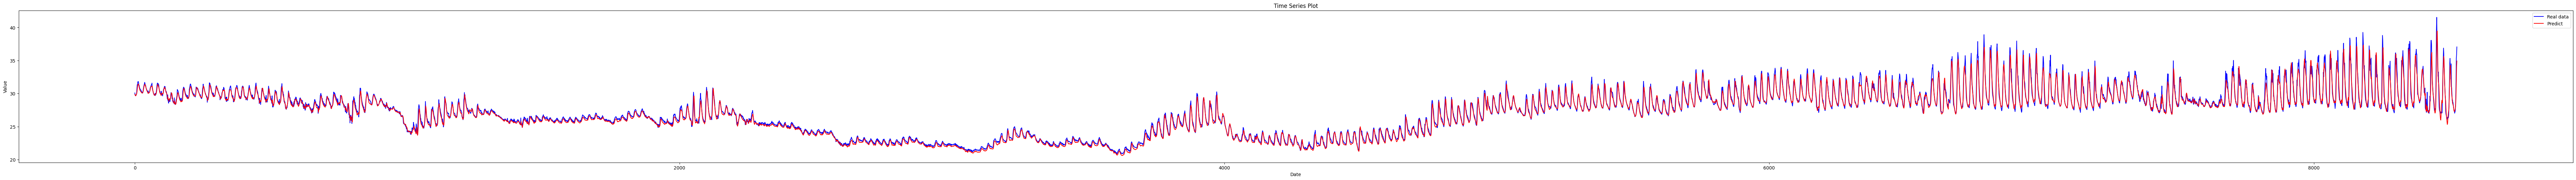

In [102]:
time = np.arange(len(y_predict))
plt.figure(figsize=(100,6))
plt.plot(time, y_test, label="Real data", color='blue')
plt.plot(time, y_predict, label="Predict",color='red')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Time Series Plot')
plt.legend()
plt.show()

In [103]:
x_train, y_train = split_train(train.to_numpy(),48)

In [104]:
model_3 = Sequential()
model_3.add(Bidirectional(LSTM(64,activation='relu', input_shape=(48,num_feature))))
model_3.add(Dense(1))
model_3.compile(optimizer='adam', loss='mse')
model_3.build(input_shape=(1,48,num_feature))
model_3.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_11 (Bidirect  (1, 128)                  33792     
 ional)                                                          
                                                                 
 dense_11 (Dense)            (1, 1)                    129       
                                                                 
Total params: 33921 (132.50 KB)
Trainable params: 33921 (132.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [105]:
model_3.fit(x_train, y_train, epochs=10)
model_3.save('./model/Bidirect-LSTM_48h_1feature_64node.h5')

Epoch 1/10
446/446 [==============================] - 8s 13ms/step - loss: 769.1174
Epoch 2/10
446/446 [==============================] - 6s 14ms/step - loss: 1.5287
Epoch 3/10
446/446 [==============================] - 6s 14ms/step - loss: 1.3943
Epoch 4/10
446/446 [==============================] - 6s 14ms/step - loss: 1.1232
Epoch 5/10
446/446 [==============================] - 6s 14ms/step - loss: 1.0537
Epoch 6/10
446/446 [==============================] - 6s 14ms/step - loss: 0.9397
Epoch 7/10
446/446 [==============================] - 6s 14ms/step - loss: 0.8397
Epoch 8/10
446/446 [==============================] - 6s 14ms/step - loss: 0.8815
Epoch 9/10
446/446 [==============================] - 6s 14ms/step - loss: 0.8410
Epoch 10/10
446/446 [==============================] - 6s 14ms/step - loss: 0.7451


e:\EXTERNALC\Python\311\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [106]:
x_test, y_test = split_train(test.to_numpy(),72)
y_predict = np.array(model_3.predict(x_test))
y_test = y_test.ravel()
y_predict = y_predict.ravel()
mse = mean_squared_error(y_test, y_predict)
mae = mean_absolute_error(y_test, y_predict)
print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)

260/260 [==============================] - 2s 7ms/step
Mean Squared Error (MSE): 879308.6845028205
Mean Absolute Error (MAE): 895.3168849157178


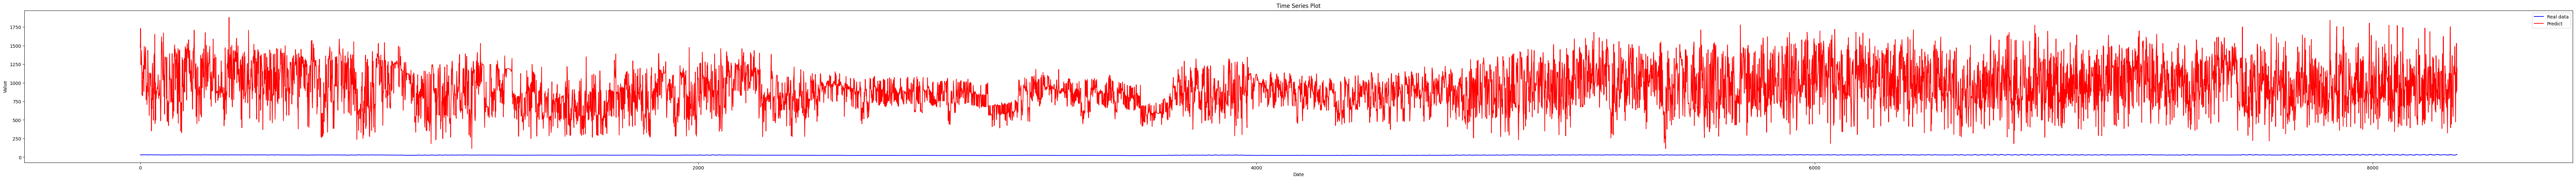

In [107]:
time = np.arange(len(y_predict))
plt.figure(figsize=(100,6))
plt.plot(time, y_test, label="Real data", color='blue')
plt.plot(time, y_predict, label="Predict",color='red')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Time Series Plot')
plt.legend()
plt.show()

In [120]:
x_train, y_train = split_train(train.to_numpy(),time_step)

In [121]:
model_4 = Sequential()
model_4.add(Bidirectional(LSTM(128,activation='relu', input_shape=(time_step,num_feature))))
model_4.add(Dense(1))
model_4.compile(optimizer='adam', loss='mse')
model_4.build(input_shape=(1,time_step,num_feature))
model_4.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_13 (Bidirect  (1, 256)                  133120    
 ional)                                                          
                                                                 
 dense_13 (Dense)            (1, 1)                    257       
                                                                 
Total params: 133377 (521.00 KB)
Trainable params: 133377 (521.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [122]:
model_4.fit(x_train, y_train, epochs=10)
model_4.save('./model/Bidirect-LSTM_24h_1feature_64node.h5')

Epoch 1/10
446/446 [==============================] - 24s 43ms/step - loss: 44437.4570
Epoch 2/10
446/446 [==============================] - 24s 54ms/step - loss: 12.7941
Epoch 3/10
446/446 [==============================] - 23s 52ms/step - loss: 12.1338
Epoch 4/10
446/446 [==============================] - 20s 44ms/step - loss: 11.5017
Epoch 5/10
446/446 [==============================] - 23s 52ms/step - loss: 10.6279
Epoch 6/10
446/446 [==============================] - 25s 56ms/step - loss: 10.1159
Epoch 7/10
446/446 [==============================] - 27s 60ms/step - loss: 9.1589
Epoch 8/10
446/446 [==============================] - 25s 57ms/step - loss: 8.6795
Epoch 9/10
446/446 [==============================] - 26s 58ms/step - loss: 8.0406
Epoch 10/10
446/446 [==============================] - 24s 53ms/step - loss: 6.9986


e:\EXTERNALC\Python\311\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [111]:
x_test, y_test = split_train(test.to_numpy(),time_step)
y_predict = np.array(model_4.predict(x_test))
y_test = y_test.ravel()
y_predict = y_predict.ravel()
mse = mean_squared_error(y_test, y_predict)
mae = mean_absolute_error(y_test, y_predict)
print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)

267/267 [==============================] - 2s 5ms/step
Mean Squared Error (MSE): 0.17904556808689132
Mean Absolute Error (MAE): 0.26803869205662556


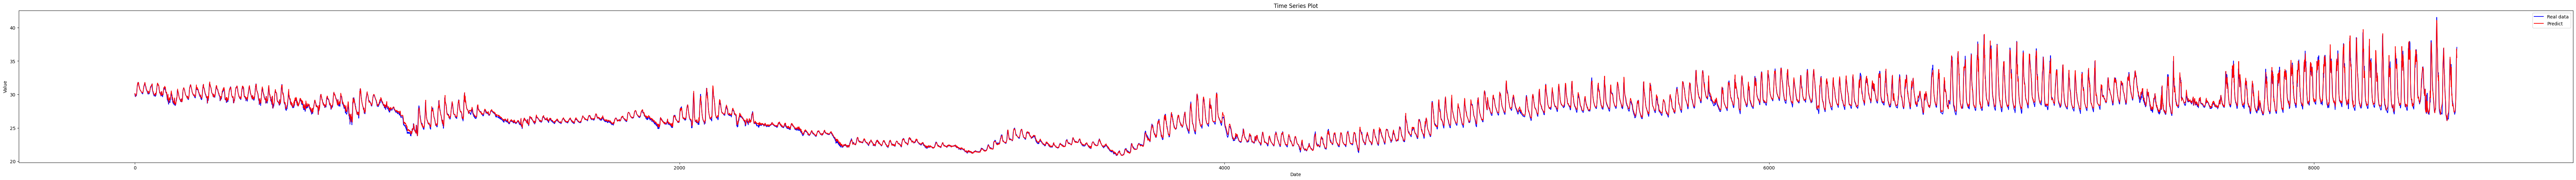

In [112]:
time = np.arange(len(y_predict))
plt.figure(figsize=(100,6))
plt.plot(time, y_test, label="Real data", color='blue')
plt.plot(time, y_predict, label="Predict",color='red')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Time Series Plot')
plt.legend()
plt.show()

XGBoost

In [113]:
time_step = 48

In [117]:
x_train, y_train = split_train(train.to_numpy(),time_step)
x_test, y_test = split_train(test.to_numpy(),time_step)

In [118]:
x_train = x_train.reshape(-1,48)
y_train = y_train.reshape(-1)
x_test = x_test.reshape(-1,48)
y_test = y_test.reshape(-1)
x_train = pd.DataFrame(x_train)
x_test = pd.DataFrame(x_test)

e:\EXTERNALC\Python\311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
e:\EXTERNALC\Python\311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
e:\EXTERNALC\Python\311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
e:\EXTERNALC\Python\311\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
e:\EX

Mean Squared Error (MSE): 0.27076759125588185
Mean Absolute Error (MAE): 0.28413483849814647


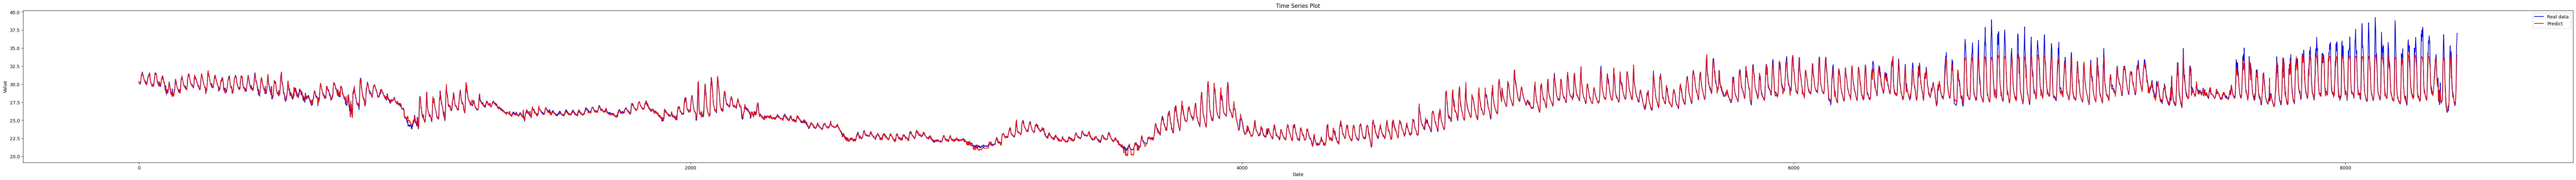

In [119]:
params = {
    'objective': 'reg:squarederror',
    'n_estimators': 100,
    'max_depth': 24,
    'learning_rate': 0.1,
    'subsample': 0.8
}
model_5 = xgb.XGBRegressor(**params)
model_5.fit(x_train,y_train)
y_predict = model_5.predict(x_test)
y_predict  = y_predict.ravel()
mse = mean_squared_error(y_test, y_predict)
mae = mean_absolute_error(y_test, y_predict)
print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
time = np.arange(len(y_predict))
plt.figure(figsize=(100,6))
plt.plot(time, y_test, label="Real data", color='blue')
plt.plot(time, y_predict, label="Predict",color='red')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Time Series Plot')
plt.legend()
plt.show()



Load Model

In [ ]:
# model_1 = load_model('./model/Bidirect-LSTM_24h_1feature.h5')
# model_1.build(input_shape=(1,time_step,num_feature))
# model_1.summary()

Predicting 3 day ahead of 24 hour data point

In [ ]:
# def period_predict(array: np.array, hours_predict:int):
#     y_hat = np.empty((array.shape[0],0))
#     for i in range(hours_predict):
#         y_hat = np.column_stack((y_hat,np.array(model_1.predict(array[:,i:])).reshape(-1,1)))
#         array = np.column_stack((array,y_hat[:,-1].reshape(-1,1,1)))
#     return y_hat.reshape(y_hat.shape[0],y_hat.shape[1],1)

# def split_test(array: np.array, duration: int, hours_predict:int):
#     x = np.empty((0,duration))
#     y = np.empty((0,hours_predict))
#     for i in range(array.shape[0]-duration-hours_predict-1):
#         new_row_x = array[i:i+duration].reshape(1, duration)
#         new_row_y = array[i+duration:i+duration+hours_predict].reshape(1, hours_predict)
#         if (np.any(np.isnan(new_row_x)) or np.any(np.isnan(new_row_y))): continue
#         else:
#             x = np.concatenate((x,new_row_x),axis=0)
#             y = np.concatenate((y,new_row_y),axis=0)
#     return x.reshape(x.shape[0],x.shape[1],1), y.reshape(y.shape[0],y.shape[1],1)

In [ ]:
# new_x_test, new_y_test = split_test(test.to_numpy(), time_step, 3*24)
# new_y_predict = period_predict(new_x_test,3*24)

# new_y_test = new_y_test.ravel()
# new_y_predict = new_y_predict.ravel()
# new_mse = mean_squared_error(new_y_test, new_y_predict)
# new_mae = mean_absolute_error(new_y_test, new_y_predict)
# print("Mean Squared Error (MSE):", new_mse)
# print("Mean Absolute Error (MAE):", new_mae)

In [ ]:
# diff = np.abs(y_predict - y_test)
# print(max(diff))